#  Capstone Project for IBM Data Science Professional Course
## Segmenting and Clustering Neighborhoods in Budapest

## Introduction

In this jupyter notebook I will implement the Capstone Project Assignment - Segmenting and Clustering Neighborhoods in Budapest, which is part of the Applied Data Science Capstone Course at coursera.com .<br>

Using FourSquare API location data, I will build a profile of Budapest neighborhoods, that could be a valuable tool for eg. a travel/real estate agency so they can choose which neighborhood to recommend to a customer, based on their interests.<br>

So let's get started.


Here I import the libraries that we will be using throughout this Notebook.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans # import k-means from clustering stage

from wordcloud import WordCloud #for wordcloud analysis

## Collecting the data - neigboorhoods

I found the most comprehensive list of Budapest neighborhoods in a WikiPedia article:<br><br>
https://en.wikipedia.org/wiki/List_of_districts_in_Budapest<br><br>
The data is in well-defined tabular format,<br>
With pandas read_html() procedure I read the neighborhood table into a dataframe.

In [2]:
wiki_df=pd.read_html("https://en.wikipedia.org/wiki/List_of_districts_in_Budapest", header = 0)[0]
wiki_df.head()

,District number,District name,Neighborhoods,Sights
0,I.,Várkerület(Castle District),"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...","Buda Castle, Matthias Church, Hungarian Nation..."
1,II.,none,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...","Tomb of Gül Baba, Mechwart Park, Cave of Szeml..."
2,III.,Óbuda-Békásmegyer,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...","Ruins of Aquincum, Aquincum Military Amphithea..."
3,IV.,Újpest(New Pest),"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...","Queen of Heavens Church, Synagogue of Újpest, ..."
4,V.,Belváros-Lipótváros(Inner City-Leopold Town),"Inner City, Lipótváros","Parliament, Hungarian Academy of Sciences, Gre..."


Some data wrangling is needed in order to extract a list of Budapest neighborhood names

In [3]:
# In some rows, there is a dot after the neighborhood names, let's remove them
wiki_df['Neighborhoods'] = wiki_df['Neighborhoods'].str.replace('.','')

# In the rows, the neighborhood names are separated with comma, let's split them
nbrh_names = wiki_df['Neighborhoods'].str.split(", ", expand = False)
nbrh_names

0     [Buda Castle, Tabán, Gellérthegy, Krisztinavár...
1     [Adyliget, Budakeszierdő, Budaliget, Csatárka,...
2     [Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csil...
3     [Újpest, Megyer, Káposztásmegyer, Székesdűlő, ...
4                              [Inner City, Lipótváros]
5                                          [Terézváros]
6                                       [Erzsébetváros]
7          [Józsefváros, Kerepesdűlő, Tisztviselőtelep]
8     [Ferencváros, Gubacsidűlő, József Attila-lakót...
9     [Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya...
10    [Albertfalva, Dobogó, Gazdagrét, Gellérthegy, ...
11    [Budakeszierdő, Csillebérc, Farkasrét, Farkasv...
12    [Újlipótváros, Angyalföld, Vizafogó, Népsziget...
13    [Alsórákos, Herminamező, Istvánmező, Kiszugló,...
14                  [Rákospalota, Pestújhely, Újpalota]
15    [Mátyásföld, Sashalom, Cinkota, Rákosszentmihá...
16    [Rákoskeresztúr, Rákoscsaba, Rákoscsaba-Újtele...
17                     [Pestszentlőrinc, Pestsze

So, there are 23 rows with lists of neighborhood names.<br>
I collect all the neigbhorhood names in a dataframe called neighborhood_df

In [4]:
nbrh_names = sum(nbrh_names, [])
nbrh_df = pd.DataFrame({'Neighborhood':nbrh_names})
nbrh_df

,Neighborhood
0,Buda Castle
1,Tabán
2,Gellérthegy
3,Krisztinaváros
4,southern Víziváros
...,...
161,Budatétény
162,Nagytétény
163,Budafok
164,Soroksár


That's it, there are 166 different neighborhoods in Budapest!<br>
There were no GPS coordinates in the WikiPedia article , so I will use the Nominatim library to collect them.<br>
First, let's see if we can collect GPS data for all neighborhoods.

In [5]:
geolocator = Nominatim(user_agent="budapest_explorer")

# initialize list for collecting neigbhorhoods with and without errors
to_fix = []
latitude = []
longitude = []

#cycle through the neighborhood list
for nbrh in nbrh_df['Neighborhood']:
    
    # let's add Budapest to the address
    address = "Budapest, " + nbrh
    
    # location lookup
    location = geolocator.geocode(address, timeout=1)
    
    #if no succes, the neighborhood is collected
    if not location:
        print("*****  " + address + ": !!! GPS NOK !!!")
        to_fix.append(nbrh)
        latitude.append(0)
        longitude.append(0)
        
    #otherwise, latitude and longitude is collected    
    else:
        print(address + ": GPS OK ")
        latitude.append(location.latitude)
        longitude.append(location.longitude)
        
print("GPS lookup finished")
    

Budapest, Buda Castle: GPS OK 
Budapest, Tabán: GPS OK 
Budapest, Gellérthegy: GPS OK 
Budapest, Krisztinaváros: GPS OK 
*****  Budapest, southern Víziváros: !!! GPS NOK !!!
Budapest, Adyliget: GPS OK 
Budapest, Budakeszierdő: GPS OK 
Budapest, Budaliget: GPS OK 
Budapest, Csatárka: GPS OK 
Budapest, Erzsébetliget: GPS OK 
Budapest, Erzsébettelek: GPS OK 
Budapest, Felhévíz: GPS OK 
Budapest, Gercse: GPS OK 
Budapest, Hársakalja: GPS OK 
Budapest, Hárshegy: GPS OK 
Budapest, Hűvösvölgy: GPS OK 
Budapest, Kővár: GPS OK 
Budapest, Kurucles: GPS OK 
Budapest, Lipótmező: GPS OK 
Budapest, Máriaremete: GPS OK 
Budapest, Nyék: GPS OK 
Budapest, Országút: GPS OK 
Budapest, Pálvölgy: GPS OK 
Budapest, Pasarét: GPS OK 
Budapest, Pesthidegkút-Ófalu: GPS OK 
Budapest, Petneházy-rét: GPS OK 
Budapest, Remetekertváros: GPS OK 
Budapest, Rézmál: GPS OK 
Budapest, Rózsadomb: GPS OK 
Budapest, Szemlőhegy: GPS OK 
Budapest, Széphalom: GPS OK 
Budapest, Szépilona: GPS OK 
Budapest, Szépvölgy: GPS OK 
Bu

Lookup finished, I add coordnates to nbrh_df.

In [6]:
nbrh_df['Latitude'] = latitude
nbrh_df['Longitude'] = longitude
nbrh_df.head()

,Neighborhood,Latitude,Longitude
0,Buda Castle,47.495991,19.039801
1,Tabán,47.490893,19.042639
2,Gellérthegy,47.484565,19.038769
3,Krisztinaváros,47.496865,19.029776
4,southern Víziváros,0.000000,0.000000


Let's see the list with the neighborhoods where GPS coordinates are still missing.

In [7]:
to_fix

['southern Víziváros',
 'northern Víziváros',
 'Inner City',
 'Szentgyörgytelep',
 'Huszkatelep']

I spoted in the Nominatim querry output that for 'Buda Castle' and 'City Park', the name is not in Hungarian.<br>
In order to keep the naming consistent, I add them to the fix-list.

In [8]:
to_fix.append("City Park")
to_fix.append("Buda Castle")
to_fix

['southern Víziváros',
 'northern Víziváros',
 'Inner City',
 'Szentgyörgytelep',
 'Huszkatelep',
 'City Park',
 'Buda Castle']

So we have 7 neighborhoods, where GPS coordinates are still missing and/or the name needs to be put into Hungarian<br>
This is not much, it can be fixed manually.
Regarding the missing coordinates: I did some web research - I used Google Maps and terkepem.hu data<br>
Now, let's delete the problem rows and add the corrected ones.

In [9]:
nbrh_df.loc[nbrh_df['Neighborhood'].isin(to_fix)]

,Neighborhood,Latitude,Longitude
0,Buda Castle,47.495991,19.039801
4,southern Víziváros,0.000000,0.000000
36,northern Víziváros,0.000000,0.000000
64,Inner City,0.000000,0.000000
126,City Park,47.514460,19.084921
139,Szentgyörgytelep,0.000000,0.000000
141,Huszkatelep,0.000000,0.000000


In [10]:
nbrh_df = nbrh_df.drop([0, 4, 36, 64, 126,  139, 141])
nbrh_df

,Neighborhood,Latitude,Longitude
1,Tabán,47.490893,19.042639
2,Gellérthegy,47.484565,19.038769
3,Krisztinaváros,47.496865,19.029776
5,Adyliget,47.547550,18.938984
6,Budakeszierdő,47.510273,18.951182
...,...,...,...
161,Budatétény,47.417128,19.010657
162,Nagytétény,47.397568,18.985958
163,Budafok,47.427530,19.026078
164,Soroksár,47.402548,19.118460


I create a dataframe with the correction data.

In [11]:
correction = {
    'Neighborhood': ['Budavári Palota', 'Víziváros-Észak', 'Víziváros-Dél', 'Belváros', 'Városliget', 'Szentgyörgytelep', 'Huszkatelep'],
    'Latitude':[47.4959913, 47.509141, 47.501922, 47.492360, 47.514460299999996, 47.534220, 47.512162],
    'Longitude':[19.03980079634199, 19.034342, 19.037925, 19.055560, 19.084921166667407, 19.168253, 19.183336]
}
correction_df = pd.DataFrame(correction, columns = ['Neighborhood', 'Latitude', 'Longitude'])
print(correction_df)

       Neighborhood   Latitude  Longitude
0   Budavári Palota  47.495991  19.039801
1   Víziváros-Észak  47.509141  19.034342
2     Víziváros-Dél  47.501922  19.037925
3          Belváros  47.492360  19.055560
4        Városliget  47.514460  19.084921
5  Szentgyörgytelep  47.534220  19.168253
6       Huszkatelep  47.512162  19.183336


Now I append the corrected rows to the existing dataframe.

In [12]:
nbrh_df = nbrh_df.append(correction_df, ignore_index = True)
print(nbrh_df)

         Neighborhood   Latitude  Longitude
0               Tabán  47.490893  19.042639
1         Gellérthegy  47.484565  19.038769
2      Krisztinaváros  47.496865  19.029776
3            Adyliget  47.547550  18.938984
4       Budakeszierdő  47.510273  18.951182
..                ...        ...        ...
161     Víziváros-Dél  47.501922  19.037925
162          Belváros  47.492360  19.055560
163        Városliget  47.514460  19.084921
164  Szentgyörgytelep  47.534220  19.168253
165       Huszkatelep  47.512162  19.183336

[166 rows x 3 columns]


Now we have the corrected list, let's put all the neighborhoods on a Folium map.

In [13]:
# create map of Budapest using latitude and longitude values
map_budapest = folium.Map(location=[47.4983815, 19.0404707], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(nbrh_df['Latitude'], nbrh_df['Longitude'], nbrh_df['Neighborhood']):
    label = neighborhood
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_budapest)  
    
map_budapest

In [14]:
map_budapest.save('neighborhoods.html')

Good, now we can move onto the next part,

## Collecting the data - top venues per neighborhood

Let's now collect the top venues for each neighborhood
We will use the FourSquare API, so I start with initilazinig for FourSquare

In [15]:
CLIENT_ID = '******' # your Foursquare ID
CLIENT_SECRET = '******' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

I define the function that collects the top 100 venues for a given neighborhood

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now comes the code to run the above function on each neighborhood and create a new dataframe for venues, called venues_df

In [17]:
venues_df = getNearbyVenues(names=nbrh_df['Neighborhood'],
                                   latitudes=nbrh_df['Latitude'],
                                   longitudes=nbrh_df['Longitude']
                                  )

Tabán
Gellérthegy
Krisztinaváros
Adyliget
Budakeszierdő
Budaliget
Csatárka
Erzsébetliget
Erzsébettelek
Felhévíz
Gercse
Hársakalja
Hárshegy
Hűvösvölgy
Kővár
Kurucles
Lipótmező
Máriaremete
Nyék
Országút
Pálvölgy
Pasarét
Pesthidegkút-Ófalu
Petneházy-rét
Remetekertváros
Rézmál
Rózsadomb
Szemlőhegy
Széphalom
Szépilona
Szépvölgy
Törökvész
Újlak
Vérhalom
Zöldmál
Óbuda
Aquincum
Aranyhegy
Békásmegyer
Csillaghegy
Csúcshegy
Filatorigát
Hármashatár-hegy
Kaszásdűlő
Mátyáshegy
Mocsárosdűlő
Óbudai-sziget
Remetehegy
Rómaifürdő
Solymárvölgy
Szépvölgy
Táborhegy
Testvérhegy
Törökkő
Ürömhegy
Újlak
Újpest
Megyer
Káposztásmegyer
Székesdűlő
Istvántelek
Lipótváros
Terézváros
Erzsébetváros
Józsefváros
Kerepesdűlő
Tisztviselőtelep
Ferencváros
Gubacsidűlő
József Attila-lakótelep
Felsőrákos
Gyárdűlő
Keresztúridűlő
Kőbánya-Kertváros
Albertfalva
Dobogó
Gazdagrét
Gellérthegy
Hosszúrét
Kamaraerdő
Kelenföld
Kelenvölgy
Kőérberek
Lágymányos
Madárhegy
Őrmező
Örsöd
Péterhegy
Pösingermajor
Sasad
Sashegy
Spanyolrét
Tabán
Bu

In [18]:
venues_df

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tabán,47.490893,19.042639,Asztalka,47.492193,19.044231,Dessert Shop
1,Tabán,47.490893,19.042639,Szent Gellért-szobor,47.489647,19.045482,Outdoor Sculpture
2,Tabán,47.490893,19.042639,Filozófusok kertje,47.489381,19.039051,Sculpture Garden
3,Tabán,47.490893,19.042639,Prezent,47.491882,19.044963,Gift Shop
4,Tabán,47.490893,19.042639,Picnic,47.491330,19.044697,Café
...,...,...,...,...,...,...,...
2597,Huszkatelep,47.512162,19.183336,"Fuvallat u. M (44, 92, 908)",47.509878,19.185031,Bus Stop
2598,Huszkatelep,47.512162,19.183336,Bétacom,47.509563,19.181276,Electronics Store
2599,Huszkatelep,47.512162,19.183336,Thor fitness,47.509306,19.179608,Athletics & Sports
2600,Huszkatelep,47.512162,19.183336,Spar,47.508780,19.180218,Grocery Store


Let's do onehot encoding.

In [19]:
# one hot encoding
budapest_onehot = pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
budapest_onehot['Neighborhood'] = venues_df['Neighborhood']
# move neigbhorhood column to the first column
budapest_onehot = budapest_onehot[ ['Neighborhood'] + [ col for col in budapest_onehot.columns if col != 'Neighborhood' ] ]
budapest_onehot

,Neighborhood,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Video Store,Vietnamese Restaurant,Vineyard,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Tabán,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Tabán,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Tabán,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tabán,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tabán,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,Huszkatelep,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2598,Huszkatelep,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2599,Huszkatelep,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2600,Huszkatelep,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's group the venues by neigbhorhood.

In [20]:
budapest_grouped = budapest_onehot.groupby('Neighborhood').mean().reset_index()
budapest_grouped

,Neighborhood,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Video Store,Vietnamese Restaurant,Vineyard,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Adyliget,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,Akadémiaújtelep,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,Albertfalva,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,Alsórákos,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,Angyalföld,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Újlak,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.018519,0.0,0.0,0.0,0.0,0.018519,0.0,0.0,0.000000
151,Újlipótváros,0.0,0.0,0.0,0.0,0.032787,0.016393,0.0,0.0,0.0,...,0.0,0.016393,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.016393
152,Újpalota,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
153,Újpest,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.041667


Let's now create 5 clusters for the neighborhoods based on their similarities.
I will use k-means clustering.

In [21]:
# set number of clusters
kclusters = 3

budapest_grouped_clustering = budapest_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(budapest_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 0, 1, 0, 0, 2, 0])

We now have the five clusters.<br>
In order to make more readable what we collected so far, lets create a dataframe with:
- the neighborhood,
- cluster number and
- the top 10 venue type for each neighborhood

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Neighborhood'] = budapest_grouped['Neighborhood']

for ind in np.arange(budapest_grouped.shape[0]):
    top_venues.iloc[ind, 1:] = return_most_common_venues(budapest_grouped.iloc[ind, :], num_top_venues)

top_venues.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyliget,Park,Pharmacy,Bus Stop,Playground,Pizza Place,Yoga Studio,Food,Fish & Chips Shop,Fish Market,Flea Market
1,Akadémiaújtelep,Bakery,Fast Food Restaurant,Pharmacy,Park,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Yoga Studio
2,Albertfalva,Pub,Bus Stop,Supermarket,Tram Station,Playground,Cafeteria,Pharmacy,Photography Studio,Dog Run,Eastern European Restaurant
3,Alsórákos,Bus Stop,Dessert Shop,Grocery Store,Plaza,Track,River,Ski Area,College Cafeteria,Pharmacy,Flea Market
4,Angyalföld,Park,Light Rail Station,Gym,Bistro,Yoga Studio,Food,Fish Market,Flea Market,Flower Shop,Food & Drink Shop


In [24]:
#we add the cluster column
top_venues['Cluster'] = kmeans.labels_
top_venues

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,Adyliget,Park,Pharmacy,Bus Stop,Playground,Pizza Place,Yoga Studio,Food,Fish & Chips Shop,Fish Market,Flea Market,1
1,Akadémiaújtelep,Bakery,Fast Food Restaurant,Pharmacy,Park,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Yoga Studio,0
2,Albertfalva,Pub,Bus Stop,Supermarket,Tram Station,Playground,Cafeteria,Pharmacy,Photography Studio,Dog Run,Eastern European Restaurant,1
3,Alsórákos,Bus Stop,Dessert Shop,Grocery Store,Plaza,Track,River,Ski Area,College Cafeteria,Pharmacy,Flea Market,1
4,Angyalföld,Park,Light Rail Station,Gym,Bistro,Yoga Studio,Food,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,0
...,...,...,...,...,...,...,...,...,...,...,...,...
150,Újlak,Café,Bakery,Sushi Restaurant,Fast Food Restaurant,Gastropub,Coffee Shop,Bar,Pub,Hungarian Restaurant,Vietnamese Restaurant,0
151,Újlipótváros,Coffee Shop,Boat or Ferry,Café,Bakery,Gourmet Shop,Dessert Shop,Park,Supermarket,Bar,Ice Cream Shop,0
152,Újpalota,Furniture / Home Store,Food & Drink Shop,Grocery Store,Plaza,Bakery,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,0
153,Újpest,Boat or Ferry,Supermarket,Pizza Place,Cosmetics Shop,Yoga Studio,Pet Store,Fast Food Restaurant,Chinese Restaurant,Park,Tea Room,0


In order to visualize the clusters, let's merge the above dataframe with nbrh_df, so we also have the GPS coordinates.

In [25]:
budapest_merged = nbrh_df

budapest_merged

# merge merge budapest_merged with  with top_venues to add latitude/longitude for each neighborhood
budapest_merged = budapest_merged.join(top_venues.set_index('Neighborhood'), on='Neighborhood')

#order columns
budapest_merged = budapest_merged[ ['Neighborhood'] + ['Latitude'] + ['Longitude'] + ['Cluster'] + [ col for col in budapest_merged.columns if col != 'Neighborhood'  and col != 'Latitude' and col != 'Longitude' and col != 'Cluster'] ]
budapest_merged


,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tabán,47.490893,19.042639,0.0,Park,Historic Site,Tram Station,Dessert Shop,Outdoor Sculpture,Sculpture Garden,Hungarian Restaurant,Scenic Lookout,Lounge,History Museum
1,Gellérthegy,47.484565,19.038769,1.0,Garden,Playground,Bus Stop,Park,Beer Garden,Library,Eastern European Restaurant,Bar,Mountain,Ice Cream Shop
2,Krisztinaváros,47.496865,19.029776,0.0,Café,Bistro,Park,Gym / Fitness Center,Bakery,Coffee Shop,Grocery Store,Playground,Cupcake Shop,Vietnamese Restaurant
3,Adyliget,47.547550,18.938984,1.0,Park,Pharmacy,Bus Stop,Playground,Pizza Place,Yoga Studio,Food,Fish & Chips Shop,Fish Market,Flea Market
4,Budakeszierdő,47.510273,18.951182,0.0,Mountain,Yoga Studio,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Víziváros-Dél,47.501922,19.037925,0.0,Café,Hotel,Restaurant,Coffee Shop,Pub,Hungarian Restaurant,Plaza,Wine Bar,Scenic Lookout,Bar
162,Belváros,47.492360,19.055560,0.0,Coffee Shop,Café,Bar,Hostel,Theater,Hotel,Plaza,Dessert Shop,Italian Restaurant,Vegetarian / Vegan Restaurant
163,Városliget,47.514460,19.084921,0.0,Park,Beer Garden,Hungarian Restaurant,Castle,Brewery,Monument / Landmark,Playground,Spa,Museum,Café
164,Szentgyörgytelep,47.534220,19.168253,2.0,Bus Stop,Pool,Food Court,Yoga Studio,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food


As you may have already noticed, we also have some neighborhoods that had no venues, let's mark them as Cluster 3.

In [26]:
budapest_merged['Cluster'].fillna(3, inplace = True)
budapest_merged

,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tabán,47.490893,19.042639,0.0,Park,Historic Site,Tram Station,Dessert Shop,Outdoor Sculpture,Sculpture Garden,Hungarian Restaurant,Scenic Lookout,Lounge,History Museum
1,Gellérthegy,47.484565,19.038769,1.0,Garden,Playground,Bus Stop,Park,Beer Garden,Library,Eastern European Restaurant,Bar,Mountain,Ice Cream Shop
2,Krisztinaváros,47.496865,19.029776,0.0,Café,Bistro,Park,Gym / Fitness Center,Bakery,Coffee Shop,Grocery Store,Playground,Cupcake Shop,Vietnamese Restaurant
3,Adyliget,47.547550,18.938984,1.0,Park,Pharmacy,Bus Stop,Playground,Pizza Place,Yoga Studio,Food,Fish & Chips Shop,Fish Market,Flea Market
4,Budakeszierdő,47.510273,18.951182,0.0,Mountain,Yoga Studio,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Víziváros-Dél,47.501922,19.037925,0.0,Café,Hotel,Restaurant,Coffee Shop,Pub,Hungarian Restaurant,Plaza,Wine Bar,Scenic Lookout,Bar
162,Belváros,47.492360,19.055560,0.0,Coffee Shop,Café,Bar,Hostel,Theater,Hotel,Plaza,Dessert Shop,Italian Restaurant,Vegetarian / Vegan Restaurant
163,Városliget,47.514460,19.084921,0.0,Park,Beer Garden,Hungarian Restaurant,Castle,Brewery,Monument / Landmark,Playground,Spa,Museum,Café
164,Szentgyörgytelep,47.534220,19.168253,2.0,Bus Stop,Pool,Food Court,Yoga Studio,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food


In [27]:
# I convert columns 'Cluster' to have integers
budapest_merged["Cluster"] = budapest_merged["Cluster"].astype(int) # I convert columns 'Cluster' to have integers
budapest_merged

,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tabán,47.490893,19.042639,0,Park,Historic Site,Tram Station,Dessert Shop,Outdoor Sculpture,Sculpture Garden,Hungarian Restaurant,Scenic Lookout,Lounge,History Museum
1,Gellérthegy,47.484565,19.038769,1,Garden,Playground,Bus Stop,Park,Beer Garden,Library,Eastern European Restaurant,Bar,Mountain,Ice Cream Shop
2,Krisztinaváros,47.496865,19.029776,0,Café,Bistro,Park,Gym / Fitness Center,Bakery,Coffee Shop,Grocery Store,Playground,Cupcake Shop,Vietnamese Restaurant
3,Adyliget,47.547550,18.938984,1,Park,Pharmacy,Bus Stop,Playground,Pizza Place,Yoga Studio,Food,Fish & Chips Shop,Fish Market,Flea Market
4,Budakeszierdő,47.510273,18.951182,0,Mountain,Yoga Studio,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Víziváros-Dél,47.501922,19.037925,0,Café,Hotel,Restaurant,Coffee Shop,Pub,Hungarian Restaurant,Plaza,Wine Bar,Scenic Lookout,Bar
162,Belváros,47.492360,19.055560,0,Coffee Shop,Café,Bar,Hostel,Theater,Hotel,Plaza,Dessert Shop,Italian Restaurant,Vegetarian / Vegan Restaurant
163,Városliget,47.514460,19.084921,0,Park,Beer Garden,Hungarian Restaurant,Castle,Brewery,Monument / Landmark,Playground,Spa,Museum,Café
164,Szentgyörgytelep,47.534220,19.168253,2,Bus Stop,Pool,Food Court,Yoga Studio,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food


Let's visualize the clusters.
I create a function that I will be using to display all clusters, or some of them.

In [28]:
#create_map procedure to display clusters - cluster_filter is a list where you can select which cluster to display
#kclusters is the number of clusters
def create_map(latitudes, longitudes, neighborhoods, clusters, cluster_filter = [0, 1, 2, 3], kclusters = 4):
    map_clusters = folium.Map(location=[47.4983815, 19.0404707], zoom_start=11)
    
    # set color scheme for the clusters
    x = np.arange(kclusters+1)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    rainbow[2] = 'grey' #neighborhoods without FourSquare data will be grey

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(latitudes, longitudes, neighborhoods, clusters):
        if cluster in cluster_filter:
            label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
            folium.CircleMarker(
                [lat, lon],
                radius=5,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_color=rainbow[cluster-1],
                fill_opacity=0.7).add_to(map_clusters)
    
    return(map_clusters)

First, I display all the clusters.

In [29]:
map_clusters = create_map(budapest_merged["Latitude"],
                          budapest_merged["Longitude"],
                          budapest_merged["Neighborhood"],
                          budapest_merged["Cluster"])
map_clusters.save('budapest_clusters.html')
map_clusters

Now, I display and save them separately. You can try and run with different values for the last parameter, which is a list of the desired cluter ids.

In [30]:
map_clusters = create_map(budapest_merged["Latitude"],
                          budapest_merged["Longitude"],
                          budapest_merged["Neighborhood"],
                          budapest_merged["Cluster"],
                          [0]
                         )
map_clusters.save('cluster_0.html')
map_clusters

In [31]:
map_clusters = create_map(budapest_merged["Latitude"],
                          budapest_merged["Longitude"],
                          budapest_merged["Neighborhood"],
                          budapest_merged["Cluster"],
                          [1]
                         )
map_clusters.save('cluster_1.html')
map_clusters

In [32]:
map_clusters = create_map(budapest_merged["Latitude"],
                          budapest_merged["Longitude"],
                          budapest_merged["Neighborhood"],
                          budapest_merged["Cluster"],
                          [2]
                         )
map_clusters.save('cluster_2.html')
map_clusters

In [33]:
map_clusters = create_map(budapest_merged["Latitude"],
                          budapest_merged["Longitude"],
                          budapest_merged["Neighborhood"],
                          budapest_merged["Cluster"],
                          [3]
                         )
map_clusters.save('cluster_3.html')
map_clusters

Let's prepare a dataframe I will be using for wordcloud analyisis for the clusters

In [34]:
top_venues = budapest_merged[budapest_merged.columns[3:]] # I need only the cluster id-s and the columns
tmp = top_venues[top_venues.columns[1:]].astype(str).agg(';'.join, axis=1) #I join the top venue strings via separator ';'
top_venues["venues"] = tmp #add new column to the dataframe
top_venues=top_venues.drop(top_venues.columns[1:11],axis=1) #drop the old columns
top_venues["venues"] = top_venues["venues"].str.replace(" ", "-") #replace spaces with '-'
top_venues["venues"] = top_venues["venues"].str.replace(";", " ") #replace ';' wit space
top_venues["venues"] = top_venues["venues"].str.replace("Bus-Stop", "") #replace less relevant Bus-Stop with blanks
top_venues

C:\Users\szako\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Cluster,venues
0,0,Park Historic-Site Tram-Station Dessert-Shop O...
1,1,Garden Playground Park Beer-Garden Library Ea...
2,0,Café Bistro Park Gym-/-Fitness-Center Bakery C...
3,1,Park Pharmacy Playground Pizza-Place Yoga-Stu...
4,0,Mountain Yoga-Studio Food-Court Fish-&-Chips-S...
...,...,...
161,0,Café Hotel Restaurant Coffee-Shop Pub Hungaria...
162,0,Coffee-Shop Café Bar Hostel Theater Hotel Plaz...
163,0,Park Beer-Garden Hungarian-Restaurant Castle B...
164,2,Pool Food-Court Yoga-Studio Food-&-Drink-Shop...


Now I create a function 'create_word' to assist with generating word clouds with the top venues for the clusters

In [35]:
#with cluster_filter, you can filter the top venue strings based on the cluster id
def create_words(clusters, words, cluster_filter = [0,1,2,3]):
    result = ""
    for cluster, word in zip(clusters,words):
        if cluster in cluster_filter:
            result = result + ' ' + word
    return(result)    

With the below code, you can generate word clouds for some or all of the clusters.<br>

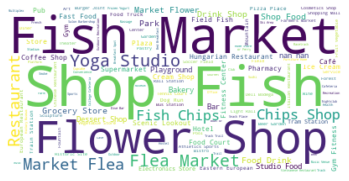

In [36]:
wc = WordCloud(background_color = "white").generate(create_words(top_venues["Cluster"],top_venues["venues"], [0,1,2,3] ))
wc.to_file('cloud_all.png')
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

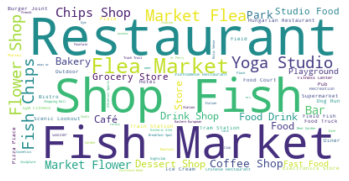

In [37]:
wc = WordCloud(background_color = "white").generate(create_words(top_venues["Cluster"],top_venues["venues"], [0] ))
wc.to_file('cloud_0.png')
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

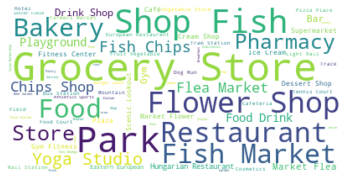

In [38]:
wc = WordCloud(background_color = "white").generate(create_words(top_venues["Cluster"],top_venues["venues"], [1] ))
wc.to_file('cloud_1.png')
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

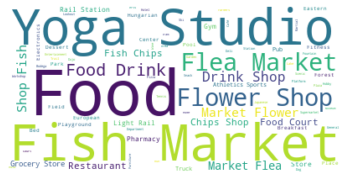

In [39]:
wc = WordCloud(background_color = "white").generate(create_words(top_venues["Cluster"],top_venues["venues"], [2] ))
wc.to_file('cloud_2.png')
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

And with this, we have come to the end of this notebook.<br>
Thank you for watching!<br><br>
In case you are interested, you can check out my GitHub repository for this project:<br>
https://github.com/pszakos/IBM-Data-Science-Capstone-Project